In [1]:
from json import JSONDecodeError
import json
from src.utils.model_utils import *
from src.utils.output_formatter import *
from nervaluate import Evaluator

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [2]:
tokenizer = get_base_tokenizer()

In [3]:
sentences = []
true_responses = []

In [4]:
with open(load_config().get("test_dataset_path"), 'r') as file:
    testing_data = json.load(file)

for item in testing_data:
    if 'user' not in item or 'assistant' not in item:
        print("problem with item:", item)
    sentences.append(item['user'])
    true_responses.append(transform_to_prodigy(item['user'], item['assistant']))

## Generating Results on Testing Dataset

In [5]:
invalid_indices = set()

ensuring reproducible results

In [ ]:
fix_seed()

### Responses From Base Model

In [12]:
base_model = get_base_model()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
generated_responses_base = []
for sentence in tqdm(sentences):
    generated_responses_base.append(generate_response(sentence, base_model, tokenizer))

So we can re-use the generated responses after restarting the notebook:

In [6]:
store_results(generated_responses_base, "../assets/generation_output/base_model.txt", do_backup=True)

In [6]:
generated_responses_base = load_results("../assets/generation_output/base_model.txt")

In [7]:
invalid_json_format = 0
invalid_key = 0
pred_responses_base = []
for i in range(len(generated_responses_base)):
    predicted = []
    try:
        predicted = transform_to_prodigy(sentences[i], generated_responses_base[i])
    except (JSONDecodeError, KeyError) as err:
        if isinstance(err, KeyError):
            invalid_key += 1
        else:
            invalid_json_format += 1
        invalid_indices.add(i)
    pred_responses_base.append(predicted)

print(f"Invalid format: {invalid_json_format + invalid_key} out of {len(generated_responses_base)} times ({invalid_json_format} JSONDecodeError, {invalid_key} KeyError)")

Invalid format: 665 out of 2422 times (610 JSONDecodeError, 55 KeyError)


### Responses From Fine-tuned Model

In [ ]:
finetuned_model = get_finetuned_model("phi3mini")

In [ ]:
generated_responses_finetuned = []
for sentence in tqdm(sentences):
    generated_responses_finetuned.append(generate_response(sentence, finetuned_model, tokenizer))

In [15]:
store_results(generated_responses_finetuned, '../assets/generation_output/finetuned_phi3.txt', do_backup=True)

In [8]:
generated_responses_finetuned = load_results('../assets/generation_output/finetuned_phi3.txt')

In [9]:
invalid_json_format = 0
invalid_key = 0
pred_responses_finetuned = []
for i in range(len(generated_responses_finetuned)):
    predicted = []
    try:
        predicted = transform_to_prodigy(sentences[i], generated_responses_finetuned[i])
    except (JSONDecodeError, KeyError) as err:
        if isinstance(err, KeyError):
            invalid_key += 1
        else:
            invalid_json_format += 1
        invalid_indices.add(i)
    pred_responses_finetuned.append(predicted)
print(f"Invalid format: {invalid_json_format + invalid_key} out of {len(generated_responses_finetuned)} times ({invalid_json_format} JSONDecodeError, {invalid_key} KeyError)")

Invalid format: 2 out of 2422 times (2 JSONDecodeError, 0 KeyError)


### Responses From Base NuExtract Model

In [16]:
nuextract_config = load_config("nuextract_config.json")

In [23]:
base_nuextract = get_base_model(nuextract_config.get("model"))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
generated_responses_base_nuextract = []
for sentence in tqdm(sentences):
    generated_responses_base_nuextract.append(generate_response(sentence, base_nuextract, tokenizer, nuextract_config.get("system_prompt")))

In [25]:
store_results(generated_responses_base_nuextract, "../assets/generation_output/base_nuextract.txt", do_backup=True)

In [10]:
generated_responses_base_nuextract = load_results("../assets/generation_output/base_nuextract.txt")

In [11]:
invalid_json_format = 0
invalid_key = 0
pred_responses_base_nuextract = []
for i in range(len(generated_responses_base_nuextract)):
    predicted = []
    try:
        fixed_sentence = generated_responses_base_nuextract[i].split("\n")[0]
        default_format_sentence = numind_to_default(fixed_sentence)
        predicted = transform_to_prodigy(sentences[i], default_format_sentence)
    except (JSONDecodeError, AttributeError, KeyError) as err:
        if isinstance(err, KeyError):
            invalid_key += 1
        else:
            invalid_json_format += 1
        invalid_indices.add(i)
    pred_responses_base_nuextract.append(predicted)
print(f"Invalid format: {invalid_json_format + invalid_key} out of {len(generated_responses_base_nuextract)} times ({invalid_json_format} JSONDecodeError, {invalid_key} KeyError)")

Invalid format: 275 out of 2422 times (275 JSONDecodeError, 0 KeyError)


### Responses From Finetuned NuExtract Model

In [18]:
finetuned_nuextract = get_finetuned_model("nuextract")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/martinh2k3/anaconda3/envs/bp/lib/python3.12/site-packages/peft/tuners/lora/bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [ ]:
generated_responses_ft_nuextract = []
i = 0
for sentence in tqdm(sentences):
    if not i%100:
        store_results(generated_responses_ft_nuextract, f"../assets/generation_output/finetuned_nuextract{i}.txt")
    i += 1
    generated_responses_ft_nuextract.append(generate_response(sentence, finetuned_nuextract, tokenizer, nuextract_config.get("system_prompt")))

  0%|          | 0/2422 [00:00<?, ?it/s]The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausal

In [10]:
store_results(generated_responses_ft_nuextract, "../assets/generation_output/finetuned_nuextract.txt", do_backup=True)

In [21]:
generated_responses_ft_nuextract = load_results("../assets/generation_output/finetuned_nuextract.txt")

In [22]:
invalid_json_format = 0
invalid_key = 0
pred_responses_ft_nuextract = []
for i in range(len(generated_responses_ft_nuextract)):
    predicted = []
    try:
        fixed_sentence = generated_responses_ft_nuextract[i].split("\n")[0]
        default_format_sentence = numind_to_default(fixed_sentence)
        predicted = transform_to_prodigy(sentences[i], default_format_sentence)
    except (JSONDecodeError, AttributeError, KeyError) as err:
        if isinstance(err, KeyError):
            invalid_key += 1
        else:
            invalid_json_format += 1
        invalid_indices.add(i)
    pred_responses_ft_nuextract.append(predicted)

print(f"Invalid format: {invalid_json_format + invalid_key} out of {len(generated_responses_ft_nuextract)} times ({invalid_json_format} JSONDecodeError, {invalid_key} KeyError)")

Invalid format: 269 out of 2422 times (269 JSONDecodeError, 0 KeyError)


### Responses From OpenAI Model

In [8]:
generated_responses_openai = []
for sentence in tqdm(sentences):
    generated_responses_openai.append(generate_openai(sentence), model_name="gpt-4o-mini", provider="litellm")
    # claude-3

In [7]:
store_results(generated_responses_openai, "../assets/generation_output/openai.txt", do_backup=True)

In [23]:
generated_responses_openai = load_results("../assets/generation_output/openai.txt")

In [24]:
invalid_json_format = 0
invalid_key = 0
pred_responses_openai = []
for i in range(len(generated_responses_openai)):
    predicted = []
    try:
        predicted = transform_to_prodigy(sentences[i], generated_responses_openai[i])
    except (JSONDecodeError, KeyError) as err:
        if isinstance(err, KeyError):
            invalid_key += 1
        else:
            invalid_json_format += 1
        invalid_indices.add(i)
    pred_responses_openai.append(predicted)

print(f"Invalid format: {invalid_json_format + invalid_key} out of {len(generated_responses_openai)} times ({invalid_json_format} JSONDecodeError, {invalid_key} KeyError)")

Invalid format: 0 out of 2422 times (0 JSONDecodeError, 0 KeyError)


### Responses from Deepseek V3

In [5]:
generated_responses_deepseek = []
at = 0
for sentence in tqdm(sentences):
    at += 1
    generated_responses_deepseek.append(generate_openai(sentence, model_name="deepseek-chat", provider="deepseek"))
    if at % 100 == 0:
        with open(f'generation_output/openai{at}.txt', 'w') as file:
            file.write("\n$SEP$\n".join(generated_responses_deepseek))

In [6]:
store_results(generated_responses_deepseek, "../assets/generation_output/deepseek.txt", do_backup=True)

In [25]:
generated_responses_deepseek = load_results("../assets/generation_output/deepseek.txt")

In [26]:
invalid_json_format = 0
invalid_key = 0
pred_responses_deepseek = []
for i in range(len(generated_responses_deepseek)):
    predicted = []
    try:
        predicted = transform_to_prodigy(sentences[i], generated_responses_deepseek[i])
    except (JSONDecodeError, KeyError) as err:
        if isinstance(err, KeyError):
            invalid_key += 1
        else:
            invalid_json_format += 1
        invalid_indices.add(i)
    pred_responses_deepseek.append(predicted)

print(f"Invalid format: {invalid_json_format + invalid_key} out of {len(generated_responses_deepseek)} times ({invalid_json_format} JSONDecodeError, {invalid_key} KeyError)")

Invalid format: 4 out of 2422 times (4 JSONDecodeError, 0 KeyError)


### Separate variables for valid responses
Removing faulty data to better understand generating logic

In [27]:
cleaned_base_responses, cleaned_finetuned_responses, cleaned_nuextract_responses, cleaned_nuextract_ft_responses, cleaned_openai_responses, cleaned_deepseek_responses, cleaned_true_responses = [], [], [], [], [], [], []

for index in range(len(true_responses)):
    if index in invalid_indices:
        continue
    cleaned_base_responses.append(pred_responses_base[index])
    cleaned_finetuned_responses.append(pred_responses_finetuned[index])
    cleaned_nuextract_responses.append(pred_responses_base_nuextract[index])
    cleaned_nuextract_ft_responses.append(pred_responses_ft_nuextract[index])
    cleaned_openai_responses.append(pred_responses_openai[index])
    cleaned_deepseek_responses.append(pred_responses_deepseek[index])
    cleaned_true_responses.append(true_responses[index])

### Manual Evaluation

From previous cells, we can calculate how often the model generates an invalid response

In [28]:
print(f"Phi-3 Mini:           \t{round(665/2422*100,3)}%\t(665 out of 2422)")
print(f"Fine-tuned Phi-3 Mini:\t{round(114/2422*100,3)}%\t(114 out of 2422)")
print(f"NuExtract 1.5:        \t{round(275/2422*100,3)}%\t(275 out of 2422)")
print(f"Fine-tuned NuExtract: \t{round(269/2422*100,3)}%\t(269 out of 2422)")
print(f"GPT-4o mini:          \t0%\t\t(0 out of 2422)")
print(f"Deepseek V3:          \t{round(4/2422*100,3)}%\t(4 out of 2422)")

Phi-3 Mini:           	27.457%	(665 out of 2422)
Fine-tuned Phi-3 Mini:	4.707%	(114 out of 2422)
NuExtract 1.5:        	11.354%	(275 out of 2422)
Fine-tuned NuExtract: 	11.107%	(269 out of 2422)
GPT-4o mini:          	0%		(0 out of 2422)
Deepseek V3:          	0.165%	(4 out of 2422)


We can also draw conclusions from how many entities each model predicted. We will not consider the inputs that received an invalid response from either of the models (similar to removing rows with null values)

In [29]:
print(f"Phi-3 Mini:           \t{sum(len(x) for x in cleaned_base_responses)}")
print(f"Fine-tuned Phi-3 Mini:\t{sum(len(x) for x in cleaned_finetuned_responses)}")
print(f"NuExtract 1.5:        \t{sum(len(x) for x in cleaned_nuextract_responses)}")
print(f"Fine-tuned NuExtract: \t{sum(len(x) for x in cleaned_nuextract_ft_responses)}")
print(f"GPT-4o mini:          \t{sum(len(x) for x in cleaned_openai_responses)}")
print(f"Deepseek V3:          \t{sum(len(x) for x in cleaned_deepseek_responses)}")
print(f"True amount:          \t{sum(len(x) for x in cleaned_true_responses)}")

Phi-3 Mini:           	7185
Fine-tuned Phi-3 Mini:	6258
NuExtract 1.5:        	4677
Fine-tuned NuExtract: 	4693
GPT-4o mini:          	5102
Deepseek V3:          	3815
True amount:          	6347


We can see that the base Phi-3 Mini model greatly overestimated what was considered an entity while the larger models on the contrary underestimated it.

### NERvaluate evaluation

#### Evaluating all responses

In [30]:
evaluator = Evaluator(true_responses, pred_responses_base, tags=['Disease', 'Chemical'])
base_results = evaluator.evaluate()[0]
evaluator = Evaluator(true_responses, pred_responses_finetuned, tags=['Disease', 'Chemical'])
finetuned_results = evaluator.evaluate()[0]
evaluator = Evaluator(true_responses, pred_responses_base_nuextract, tags=['Disease', 'Chemical'])
nuextract_results = evaluator.evaluate()[0]
evaluator = Evaluator(true_responses, pred_responses_ft_nuextract, tags=['Disease', 'Chemical'])
nuextract_ft_results = evaluator.evaluate()[0]
evaluator = Evaluator(true_responses, pred_responses_openai, tags=['Disease', 'Chemical'])
openai_results = evaluator.evaluate()[0]
evaluator = Evaluator(true_responses, pred_responses_deepseek, tags=['Disease', 'Chemical'])
deepseek_results = evaluator.evaluate()[0]

In [31]:
# Prepare data in the desired format
data = []

# Iterate over each model and each metric type within the model
for model_name, model_data in zip(
    ["Base", "Fine-tuned", "NuExtract", "Fine-tuned NuExtract", "DeepSeek", "OpenAI"],
    [base_results, finetuned_results, nuextract_results, nuextract_ft_results, deepseek_results, openai_results]
):
    for metric, values in model_data.items():
        row = [model_name, metric] + list(values.values())
        data.append(row)

columns = ["Model", "Schema"] + list(base_results["ent_type"].keys())

df = pd.DataFrame(data, columns=columns)
# improve readability
df["Model"] = df["Model"].mask(df["Model"].duplicated(), "")
df.set_index(["Model", "Schema"], inplace=True)
df[["precision", "recall", "f1"]] = df[["precision", "recall", "f1"]].round(3)
# misleading for our purpose
df.drop(columns=['possible', 'actual'], inplace=True)
df


correct  incorrect  partial  missed  spurious  \
Model                Schema                                                    
Base                 ent_type     5285        209        0    4337      2692   
                     partial      4492          0     1002    4337      2692   
                     strict       4415       1079        0    4337      2692   
                     exact        4492       1002        0    4337      2692   
Fine-tuned           ent_type     8667         51        0    1103       964   
                     partial      8100          0      618    1103       964   
                     strict       8089        629        0    1103       964   
                     exact        8100        618        0    1103       964   
NuExtract            ent_type     5401        107        0    4298      1045   
                     partial      4488          0     1020    4298      1045   
                     strict       4470       1038        0    4298      1045   
                     exact        4488       1020        0    4298      1045   
Fine-tuned NuExtract ent_type     5443        106        0    4258      1059   
                     partial      4530          0     1019    4258      1059   
                     strict       4511       1038        0    4258      1059   
                     exact        4530       1019        0    4258      1059   
DeepSeek             ent_type     5382         46        0    4381       256   
                     partial      4972          0      456    4381       256   
                     strict       4968        460        0    4381       256   
                     exact        4972        456        0    4381       256   
OpenAI               ent_type     6825         72        0    2917       913   
                     partial      6196          0      701    2917       913   
                     strict       6178        719        0    2917       913   
                     exact        6196        701        0    2917       913   

                               precision  recall     f1  
Model                Schema                              
Base                 ent_type      0.646   0.538  0.587  
                     partial       0.610   0.508  0.554  
                     strict        0.539   0.449  0.490  
                     exact         0.549   0.457  0.499  
Fine-tuned           ent_type      0.895   0.882  0.889  
                     partial       0.869   0.856  0.862  
                     strict        0.835   0.824  0.830  
                     exact         0.837   0.825  0.831  
NuExtract            ent_type      0.824   0.551  0.660  
                     partial       0.763   0.510  0.611  
                     strict        0.682   0.456  0.546  
                     exact         0.685   0.458  0.549  
Fine-tuned NuExtract ent_type      0.824   0.555  0.663  
                     partial       0.763   0.514  0.614  
                     strict        0.683   0.460  0.550  
                     exact         0.686   0.462  0.552  
DeepSeek             ent_type      0.947   0.549  0.695  
                     partial       0.915   0.530  0.671  
                     strict        0.874   0.506  0.641  
                     exact         0.875   0.507  0.642  
OpenAI               ent_type      0.874   0.695  0.775  
                     partial       0.838   0.667  0.743  
                     strict        0.791   0.630  0.701  
                     exact         0.793   0.631  0.703

In [32]:
def graph_for_metric(metric_name: str, _base_results=base_results, _finetuned_results=finetuned_results, _nuextract_results=nuextract_results, _nuextract_ft_results=nuextract_ft_results, _deepseek_results=deepseek_results, _openai_results=openai_results, ax=None):
    data = {
        "Metric": list(_base_results.keys()),
        "Base Model": [_base_results[metric][metric_name] for metric in _base_results.keys()],
        "Fine-Tuned Model": [_finetuned_results[metric][metric_name] for metric in _finetuned_results.keys()],
        "NuExtract Model": [_nuextract_results[metric][metric_name] for metric in _nuextract_results.keys()],
        "Fine-tuned NuExtract Model": [_nuextract_ft_results[metric][metric_name] for metric in _nuextract_ft_results.keys()],
        "Deepseek V3": [_deepseek_results[metric][metric_name] for metric in _deepseek_results.keys()],
        "GPT-4o mini": [_openai_results[metric][metric_name] for metric in _openai_results.keys()],
    }

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(df["Metric"]))  # the label locations
    width = 0.12  # the width of the bars

    # Plot bars for each model
    ax.bar(x - width, df["Base Model"], width, label="Base Phi-3 Mini")
    ax.bar(x, df["Fine-Tuned Model"], width, label="Fine-Tuned Phi-3 Mini")
    ax.bar(x + width, df["NuExtract Model"], width, label="Base NuExtract 1.5")
    ax.bar(x + 2*width, df["Fine-tuned NuExtract Model"], width, label="Fine-tuned NuExtract 1.5")
    ax.bar(x + 3*width, df["Deepseek V3"], width, label="Deepseek V3")
    ax.bar(x + 4*width, df["GPT-4o mini"], width, label="GPT-4o mini")

    # Labels and title
    ax.set_xlabel("Evaluation Schema")
    ax.set_ylabel(f"{metric_name.capitalize()} Score")
    ax.set_title(f"Comparison of {metric_name.capitalize()} Scores Across Models")
    ax.set_xticks(x)
    ax.set_xticklabels(df["Metric"])
    ax.legend()

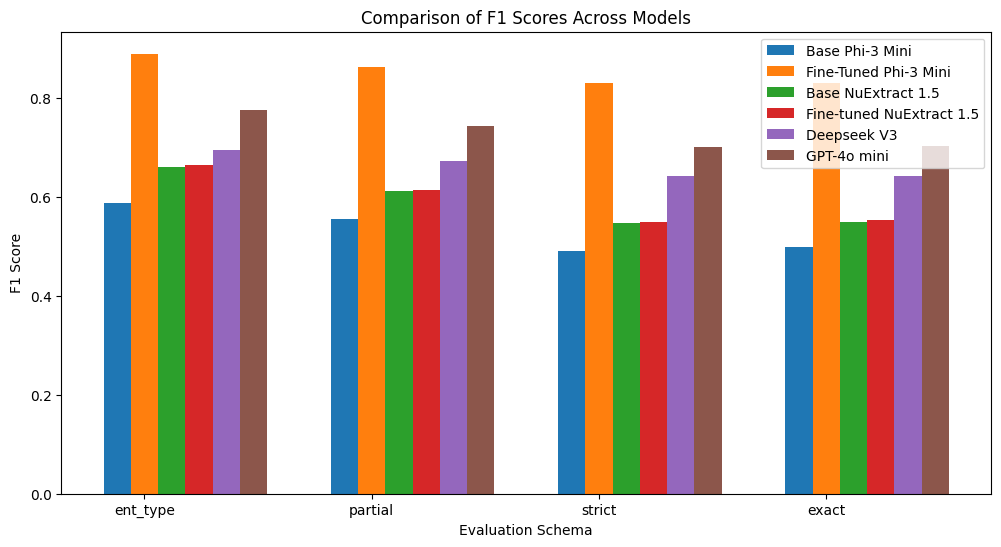

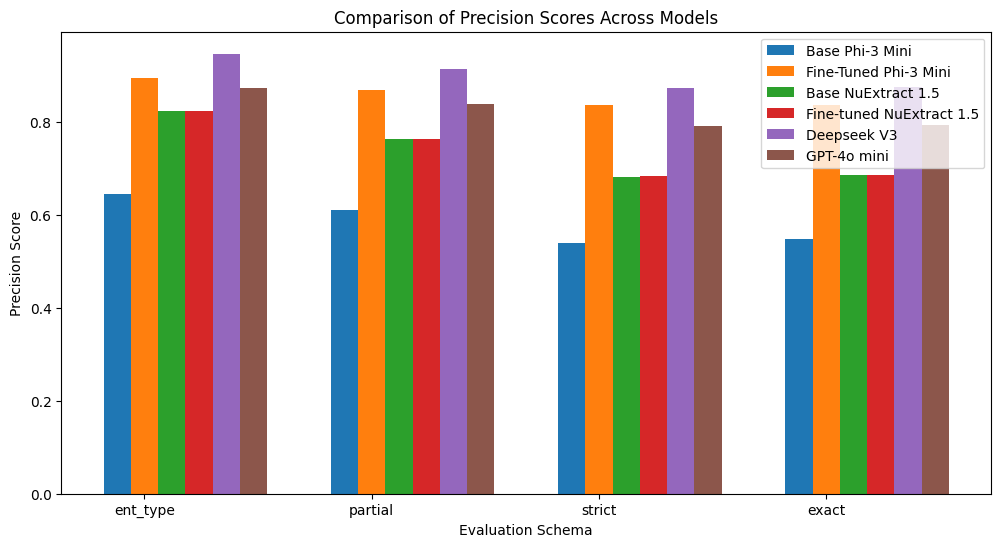

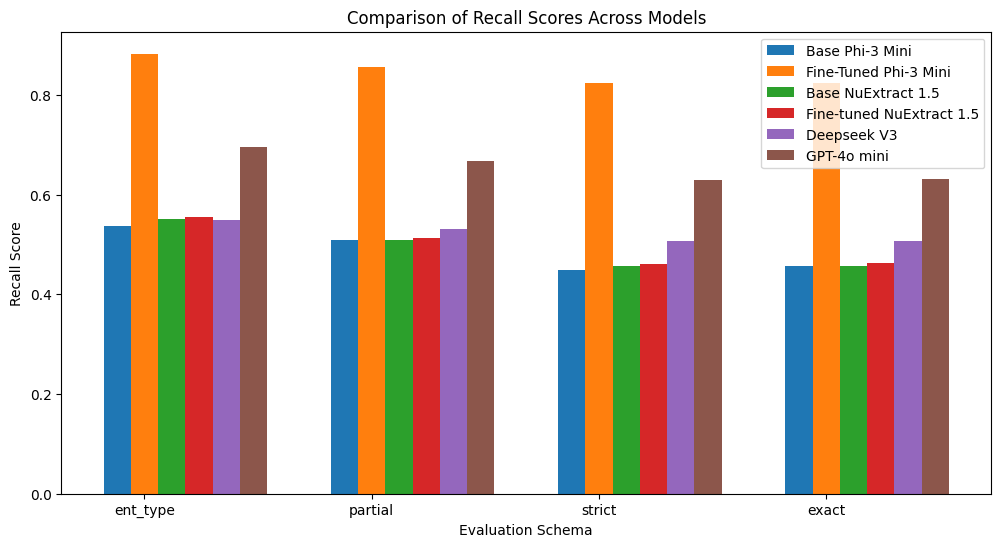

In [33]:
graph_for_metric("f1")
graph_for_metric("precision")
graph_for_metric("recall")

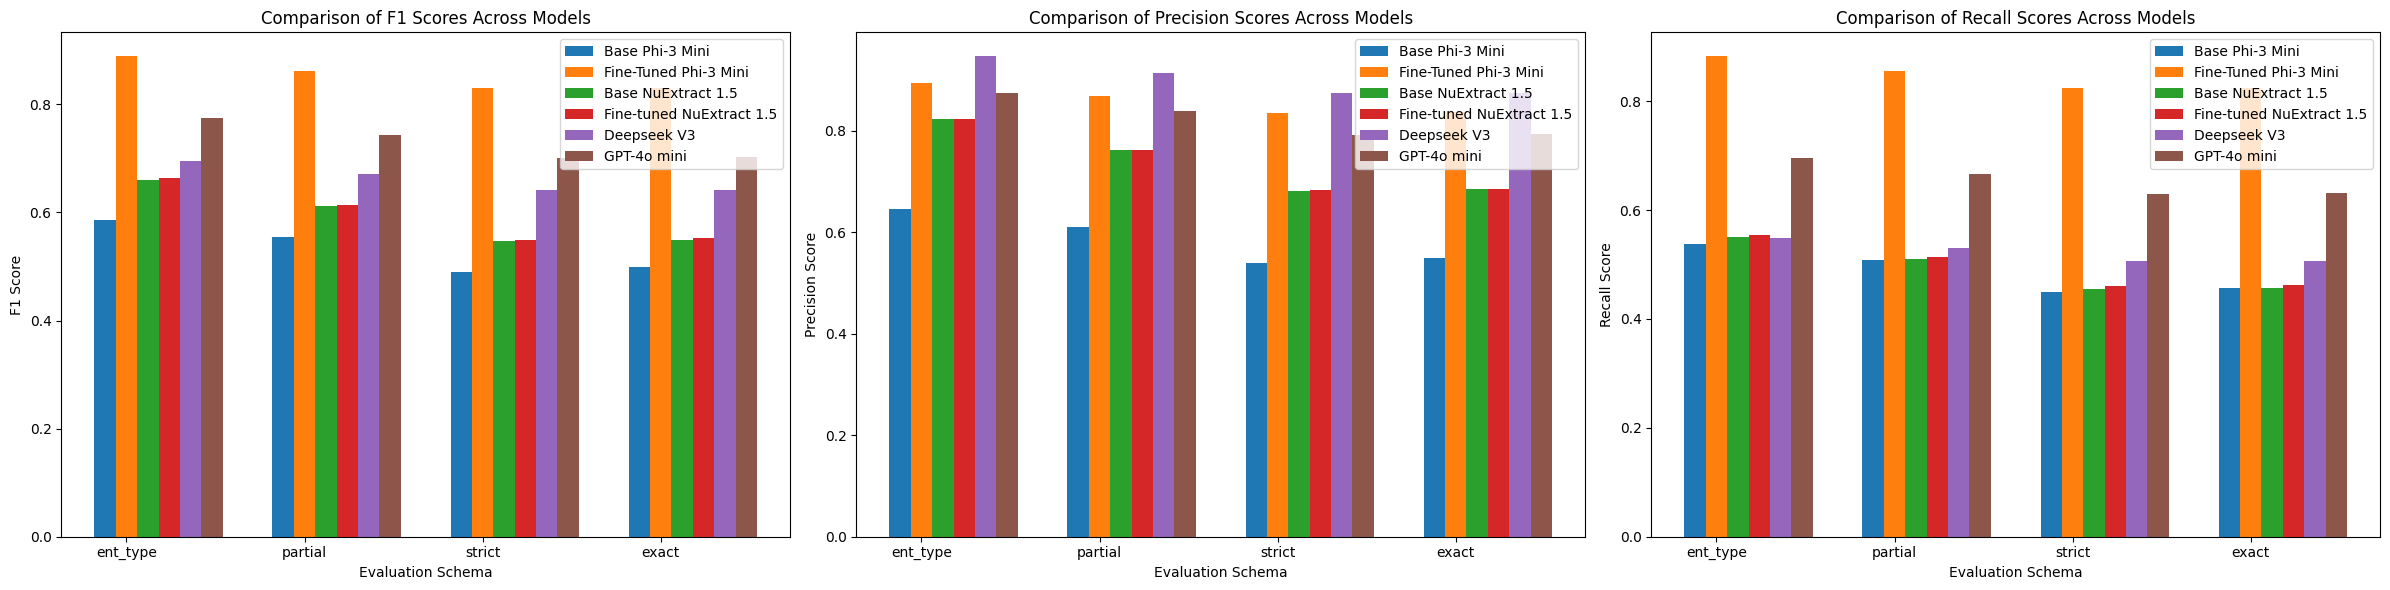

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
for i, metric in enumerate(["f1", "precision", "recall"]):
    graph_for_metric(metric, ax=axes[i])
plt.tight_layout()
plt.show()


#### Evaluating only valid responses

In [35]:
evaluator = Evaluator(cleaned_true_responses, cleaned_base_responses, tags=['Disease', 'Chemical'])
cleaned_base_results = evaluator.evaluate()[0]
evaluator = Evaluator(cleaned_true_responses, cleaned_finetuned_responses, tags=['Disease', 'Chemical'])
cleaned_finetuned_results = evaluator.evaluate()[0]
evaluator = Evaluator(cleaned_true_responses, cleaned_openai_responses, tags=['Disease', 'Chemical'])
cleaned_openai_results = evaluator.evaluate()[0]
evaluator = Evaluator(cleaned_true_responses, cleaned_deepseek_responses, tags=['Disease', 'Chemical'])
cleaned_deepseek_results = evaluator.evaluate()[0]

In [36]:
# Prepare data in the desired format
data = []

# Iterate over each model and each metric type within the model
for model_name, model_data in zip(
    ["Base", "Fine-tuned", "DeepSeek", "OpenAI"],
    [cleaned_base_results, cleaned_finetuned_results, cleaned_deepseek_results, cleaned_openai_results]
):
    for metric, values in model_data.items():
        row = [model_name, metric] + list(values.values())
        data.append(row)

columns = ["Model", "Schema"] + list(base_results["ent_type"].keys())

df = pd.DataFrame(data, columns=columns)
# improve readability
df.set_index(["Model", "Schema"], inplace=True)
df[["precision", "recall", "f1"]] = df[["precision", "recall", "f1"]].round(3)
# misleading for our purpose
df.drop(columns=['possible', 'actual'], inplace=True)
df

correct  incorrect  partial  missed  spurious  precision  \
Model      Schema                                                               
Base       ent_type     4682        173        0    1518      2300      0.654   
           partial      3983          0      872    1518      2300      0.618   
           strict       3921        934        0    1518      2300      0.548   
           exact        3983        872        0    1518      2300      0.557   
Fine-tuned ent_type     5689         33        0     640       569      0.904   
           partial      5322          0      400     640       569      0.878   
           strict       5316        406        0     640       569      0.845   
           exact        5322        400        0     640       569      0.846   
DeepSeek   ent_type     3654         30        0    2668       175      0.947   
           partial      3382          0      302    2668       175      0.916   
           strict       3378        306        0    2668       175      0.875   
           exact        3382        302        0    2668       175      0.876   
OpenAI     ent_type     4551         41        0    1761       564      0.883   
           partial      4154          0      438    1761       564      0.848   
           strict       4144        448        0    1761       564      0.804   
           exact        4154        438        0    1761       564      0.806   

                     recall     f1  
Model      Schema                   
Base       ent_type   0.735  0.692  
           partial    0.693  0.653  
           strict     0.615  0.580  
           exact      0.625  0.589  
Fine-tuned ent_type   0.894  0.899  
           partial    0.868  0.873  
           strict     0.836  0.840  
           exact      0.837  0.841  
DeepSeek   ent_type   0.575  0.716  
           partial    0.556  0.692  
           strict     0.532  0.662  
           exact      0.532  0.662  
OpenAI     ent_type   0.716  0.791  
           partial    0.688  0.760  
           strict     0.652  0.720  
           exact      0.654  0.722

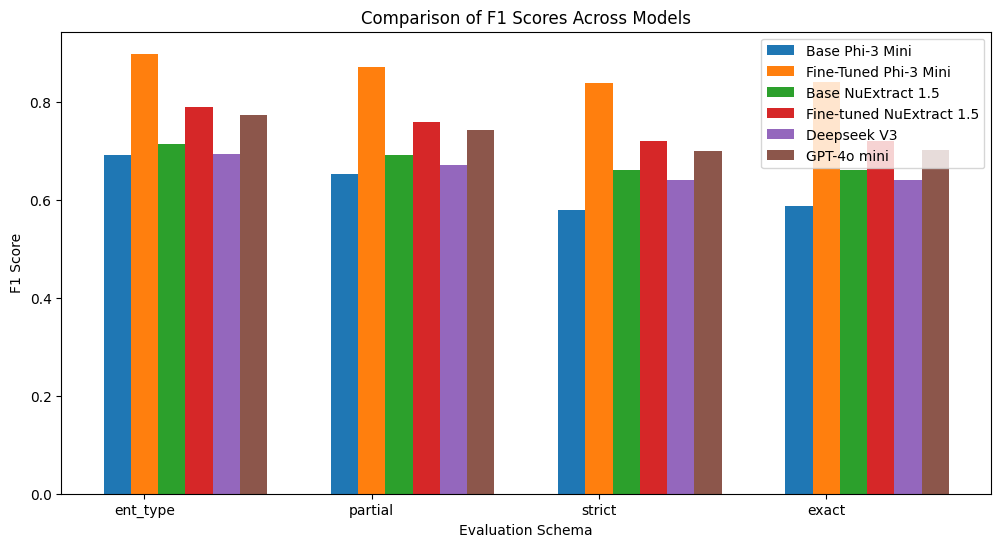

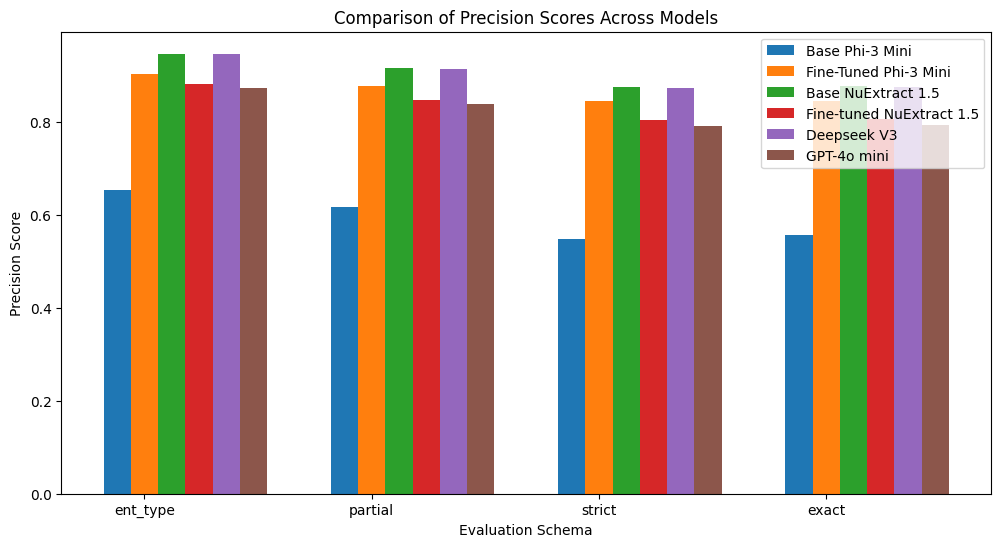

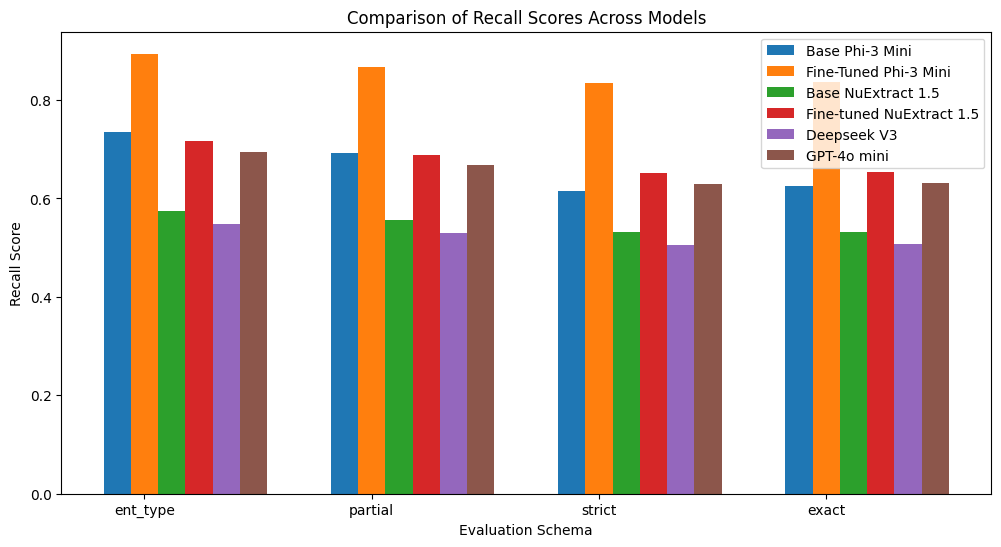

In [37]:
graph_for_metric("f1", cleaned_base_results, cleaned_finetuned_results, cleaned_deepseek_results, cleaned_openai_results)
graph_for_metric("precision", cleaned_base_results, cleaned_finetuned_results, cleaned_deepseek_results, cleaned_openai_results)
graph_for_metric("recall", cleaned_base_results, cleaned_finetuned_results, cleaned_deepseek_results, cleaned_openai_results)

#### Storing the results

In [39]:
with open("../assets/results/base_results.json", "w") as file:
    json.dump(base_results, file)
with open("../assets/results/finetuned_results.json", "w") as file:
    json.dump(finetuned_results, file)
with open("../assets/results/nuextract_results.json", "w") as file:
    json.dump(nuextract_results, file)
with open("../assets/results/nuextract_ft_results.json", "w") as file:
    json.dump(nuextract_ft_results, file)
with open("../assets/results/openai_results.json", "w") as file:
    json.dump(openai_results, file)
with open("../assets/results/deepseek_results.json", "w") as file:
    json.dump(deepseek_results, file)


### InterpretEval evaluation

In [ ]:
interpret_eval_base = prodigy_to_interpreteval(pred_responses_base)
interpret_eval_openai = prodigy_to_interpreteval(pred_responses_openai)
interpret_eval_finetuned = prodigy_to_interpreteval(pred_responses_finetuned)